In [35]:
import pyopencl as cl
import sumpy.toys as t
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from sumpy.visualization import FieldPlotter
from pytools import add_tuples

from sumpy.expansion.local import VolumeTaylorLocalExpansion
from sumpy.expansion.multipole import VolumeTaylorMultipoleExpansion
from sumpy.kernel import (YukawaKernel, HelmholtzKernel, LaplaceKernel)

order = 4

if 0:
    knl = LaplaceKernel(2)
    pde = [(1, (2,0)), (1, (0, 2))]
    extra_kernel_kwargs = {}
    
else:
    helm_k = 1.2
    knl = HelmholtzKernel(2)
    extra_kernel_kwargs={"k": helm_k}

    pde = [(1, (2,0)), (1, (0, 2)), (helm_k**2, (0, 0))]

mpole_expn = VolumeTaylorMultipoleExpansion(knl, order)
local_expn = VolumeTaylorLocalExpansion(knl, order)

cl_ctx = cl.create_some_context(answers=["port"])

tctx = t.ToyContext(
        cl_ctx,
        knl,
        mpole_expn_class=type(mpole_expn),
        local_expn_class=type(local_expn),
        extra_kernel_kwargs=extra_kernel_kwargs,
        )


In [36]:
pt_src = t.PointSources(
        tctx,
        np.random.rand(2, 50) - 0.5,
        np.ones(50))

mexp = t.multipole_expand(pt_src, [0, 0], order)

In [37]:
mexp.coeffs

array([  5.00000000e+01,   4.76258789e+00,   6.63902810e-01,
         2.17149444e+00,   6.22396090e-01,   2.36567252e+00,
         5.93173776e-02,   6.33392972e-02,   1.15590385e-01,
         2.35250166e-02,   2.60421537e-02,   1.58948983e-02,
         9.97399769e-02,   1.12510066e-02,   3.13387666e-02])

In [38]:
def build_pde_mat(expn, pde):
    coeff_ids = expn.get_coefficient_identifiers()
    id_to_index = expn._storage_loc_dict
    
    # FIXME: specific to scalar PDEs
    pde_mat = np.zeros((len(coeff_ids), len(coeff_ids)))
    
    row = 0
    for base_coeff_id in coeff_ids:
        valid = True
        
        for pde_coeff, coeff_id_offset in pde:
            other_coeff = add_tuples(base_coeff_id, coeff_id_offset)
            if not other_coeff in id_to_index:
                valid = False
                break
                
            pde_mat[row, id_to_index[other_coeff]] = pde_coeff
                
        if valid:
            row += 1
        else:
            pde_mat[row] = 0
            
    return pde_mat[:row]

pde_mat = build_pde_mat(mpole_expn, pde)

In [39]:
def find_nullspace(mat, tol=1e-10):
    u, sig, vt = la.svd(pde_mat, full_matrices=True)
    zerosig = np.where(np.abs(sig) < tol)[0]
    if zerosig:
        nullsp_start = zerosig[0]
        assert np.array_equal(zerosig, np.arange(nullsp_start, pde_mat.shape[1]))
    else:
        nullsp_start = pde_mat.shape[0]
                              
    return vt[nullsp_start:].T
    
nullsp = find_nullspace(pde_mat)

In [40]:
la.norm(pde_mat @ nullsp)

4.3183836498795062e-16

In [41]:
def build_translation_mat(mexp, to_center):
    n = len(mexp.coeffs)
    result = np.zeros((n, n))
    
    for j in range(n):
        unit_coeffs = np.zeros(n)
        unit_coeffs[j] = 1
        unit_mexp = mexp.with_coeffs(unit_coeffs)
        
        result[:, j] = t.multipole_expand(unit_mexp, to_center).coeffs
        
    return result

new_center = np.array([0, 0.5])
tmat = build_translation_mat(mexp, new_center)

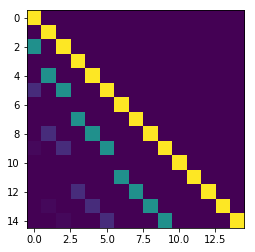

In [42]:
plt.imshow(tmat)

In [43]:
nullsp.shape

(15, 9)

In [44]:
if 1:
    reduction_mat = nullsp.T
    expansion_mat = nullsp

In [45]:
def plot_coeffs(expn, coeffs, **kwargs):
    x = [cid[0] for cid in expn.get_coefficient_identifiers()]
    y = [cid[1] for cid in expn.get_coefficient_identifiers()]
    plt.scatter(x, y, c=coeffs, **kwargs)
    plt.colorbar()

    for cid, coeff in zip(expn.get_coefficient_identifiers(), coeffs):
        plt.text(cid[0], cid[1]+0.2, "%.1f" % coeff)


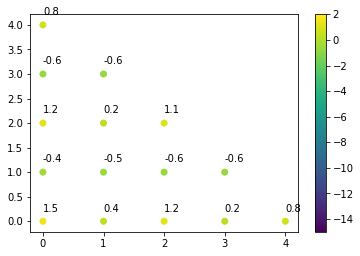

In [46]:
proj_mexp = mexp.with_coeffs(expansion_mat @ reduction_mat @ mexp.coeffs)

proj_resid = proj_mexp.coeffs - mexp.coeffs

plot_coeffs(mpole_expn, np.log10(1e-15+np.abs(proj_resid)), vmin=-15, vmax=2)

In [47]:
print(t.l_inf(proj_mexp - mexp, 1.2, center=[3,0]))

3.79429987221e-15


In [48]:
trans_unproj = t.multipole_expand(mexp, new_center)
trans_proj = t.multipole_expand(proj_mexp, new_center)

print(t.l_inf(trans_unproj - trans_proj, 1.2, center=[3,0]))

0.38107769179


In [49]:
print(trans_proj.coeffs - trans_unproj.coeffs)

[-32.9950621   -2.48614725 -16.86618617 -14.44539704  -1.56949022
 -18.88759082  -1.72649114  -7.47870901  -2.20046784  -8.27892976
   5.88044482  -1.08992376   9.7345129   -1.18252057   3.7437777 ]


In [50]:
la.norm(reduction_mat @ (trans_proj.coeffs - trans_unproj.coeffs))

4.0217762427070678

In [51]:
t.l_inf(trans_unproj - pt_src, 1.2, center=[3, 0])

/home/andreas/src/sumpy/sumpy/p2p.py:186: LoopyWarning: 'lang_version' was not passed to make_kernel(). To avoid this warning, pass lang_version=(2018, 1) in this invocation. (Or say 'from loopy.version import LOOPY_USE_LANGUAGE_VERSION_2018_1' in the global scope of the calling frame.)
  nresults=len(self.kernels)))


0.011804658035654577

In [52]:
t.l_inf(mexp - pt_src, 1.2, center=[3, 0])

0.00029429326299543407